In [52]:
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw, AllChem, DataStructs, PandasTools
from rdkit.Chem.SaltRemover import SaltRemover
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Neural network specific libraries
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

In [53]:
df = pd.read_csv("databases/acetylcholinesterase_Ki_pKi_bioactivity_data_curated.csv", index_col= 0)
df

,units,Ki,smiles,pKi
molecule_chembl_id,,,,
CHEMBL11805,nM,0.104,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...,9.982967
CHEMBL208599,nM,0.026,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,10.585027
CHEMBL60745,nM,1.630,CC[N+](C)(C)c1cccc(O)c1.[Br-],8.787812
CHEMBL95,nM,151.000,Nc1c2c(nc3ccccc13)CCCC2,6.821023
CHEMBL173309,nM,12.200,CCN(CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)CCCCCN(CC)C...,7.913640
...,...,...,...,...
CHEMBL5220695,nM,120.000,CC(C)(C)OC(=O)Nc1ccc(O)c(C(=O)NCCCN2CCCCC2)c1,6.920819
CHEMBL5219239,nM,170.000,CC1CCCCN1CCCNC(=O)c1cc(NC(=O)OC(C)(C)C)ccc1O,6.769551
CHEMBL5218804,nM,0.264,COc1cccc2c1CCC(NC(=O)OCc1ccccc1)C2,9.578396


In [54]:
print( f'number of missing values are : {df.isnull().sum().sum()}')
print (f'The shape of the dataset is : {df.shape}')

number of missing values are : 0
The shape of the dataset is : (472, 4)


In [55]:
df = df.dropna(how='any')

In [56]:
print( f'number of missing values are : {df.isnull().sum().sum()}')
print (f'The shape of the dataset is : {df.shape}')

number of missing values are : 0
The shape of the dataset is : (472, 4)


I have noiced that the data contains some molecules with salts, So I decided to remove them before going forward

In [57]:
#Strip salts

def MolStripper(smiles):
    """
    Delete salts from a molecule a return a molecules without ions.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    Returns
    -------
    array
        Moleucle as Rdkit object to as pandas series.

    """
    remover = SaltRemover() 
    mol = Chem.MolFromSmiles(smiles)
    stripped = remover.StripMol(mol)
    return pd.Series(Chem.MolToSmiles(stripped))
    

In [58]:
# Add column for Stripped molecules
df["smiles"] = df["smiles"].apply(MolStripper)
df.head(3)
# NBVAL_CHECK_OUTPUT

,units,Ki,smiles,pKi
molecule_chembl_id,,,,
CHEMBL11805,nM,0.104,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...,9.982967
CHEMBL208599,nM,0.026,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,10.585027
CHEMBL60745,nM,1.630,CC[N+](C)(C)c1cccc(O)c1,8.787812


In [61]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles')

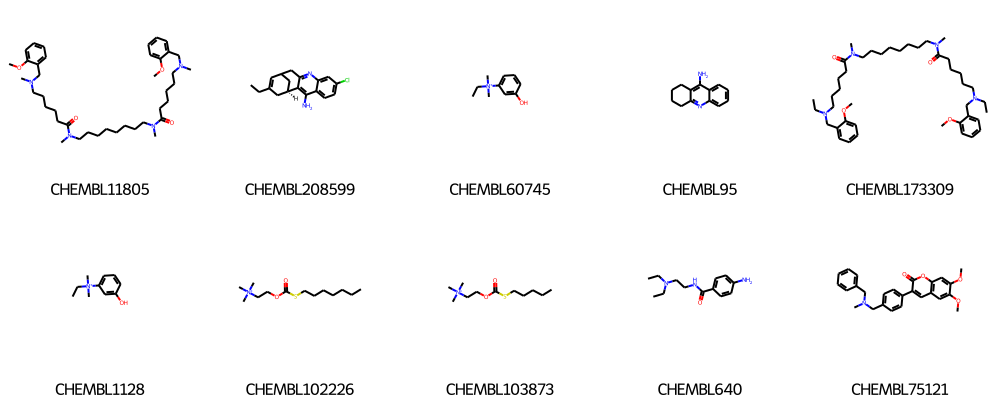

In [62]:
Draw.MolsToGridImage(list(df.ROMol[0:10]), legends = list(df.index[0:10]), molsPerRow=5)

In [63]:
#mols = [Chem.MolFromSmiles(smi) for smi in df.canonical_smiles ]

In [64]:
mols = [Chem.MolFromSmiles(smi) for smi in df.smiles ]
fp = [AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mols]

In [65]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

,units,Ki,smiles,pKi,ROMol,fp
molecule_chembl_id,,,,,,
CHEMBL11805,nM,0.104,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...,9.982967,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
CHEMBL208599,nM,0.026,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,10.585027,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
CHEMBL60745,nM,1.630,CC[N+](C)(C)c1cccc(O)c1,8.787812,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

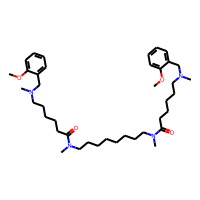
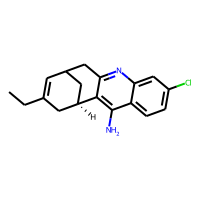
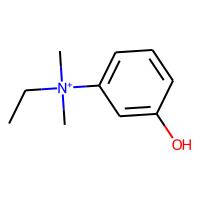

In [66]:
# Add column for fingerprint
df["fp"] = df["smiles"].apply(smiles_to_fp)
df.head(3)

### The fp_from_smiles function is very slow and running it kill the kernel of the jupyter 

In [9]:
# def fp_from_smiles(smiles):
#     output = []
#     for f in fp :
#         arr = np.zeros((1,))
#         DataStructs.ConvertToNumpyArray(f, arr)
#         output.append(arr)
#     return np.asarray(output)
#     #return pd.DataFrame(data = output, index= df.index)

In [10]:
# df["canonical_smiles"]

molecule_chembl_id
CHEMBL1795572    CO/N=C(/C(=O)NCP(=O)(O)Oc1ccc(C#N)c(F)c1)c1ccc...
CHEMBL3112752    N[C@@H](Cc1ccc(NC(=O)[C@@H]2CC[C@@H]3CN2C(=O)N...
CHEMBL3112746    O=C(Nc1ccncc1)[C@@H]1CC[C@@H]2CN1C(=O)N2OS(=O)...
CHEMBL1173339                            CCC(S)P(=O)(OC(C)C)OC(C)C
CHEMBL1172388                                      CCC(S)P(=O)(O)O
                                       ...                        
CHEMBL4088285                     CC(=O)SCC(CCCc1ccccc1)c1nnn[nH]1
CHEMBL4064978                       CC(=O)SCC(Cc1ccccc1)c1nnn[nH]1
CHEMBL4075406                           O=P(O)(O)C(CO)CCCCc1ccccc1
CHEMBL4069211                            O=P(O)(O)C(CO)CCCc1ccccc1
CHEMBL4087458                       CCOP(=O)(OCC)C(CS)CCCCc1ccccc1
Name: canonical_smiles, Length: 62226, dtype: object

In [ ]:
# df["fingerprints_df"] = df["canonical_smiles"].apply(fp_from_smiles)

# # Look at head
# print("Shape of dataframe:", df.shape)
# df.head(3)
# # NBVAL_CHECK_OUTPUT

In [73]:
df.columns

Index(['units', 'Ki', 'smiles', 'pKi', 'ROMol', 'fp'], dtype='object')

In [76]:
index = df.index

In [79]:
df.to_csv('./databases/data_fp.csv', columns=['smiles','pKi','ROMol','fp'])

,smiles,pKi,ROMol,fp
molecule_chembl_id,,,,
CHEMBL11805,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...,9.982967,,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
CHEMBL208599,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,10.585027,,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
CHEMBL60745,CC[N+](C)(C)c1cccc(O)c1,8.787812,,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,6.821023,,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
CHEMBL173309,CCN(CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)CCCCCN(CC)C...,7.913640,,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...

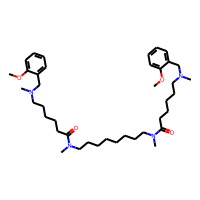
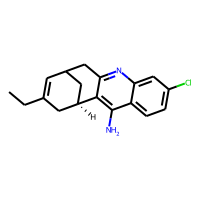
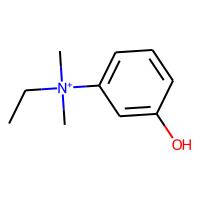
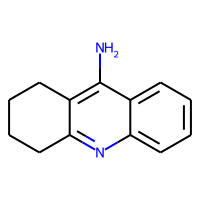
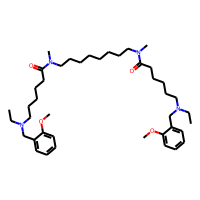

In [80]:
df = pd.read_csv('./databases//data_fp.csv', index_col=0)
df.head()

In [82]:
df['fp'][0]

'[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1\n 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1\n 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]'

In [87]:
#df['fp'].apply(pd.to_numeric, downcast='float')

In [95]:
print("The shape of the dataset is ",df.shape)

The shape of the dataset is  (472, 4)


In [90]:
df.isnullisnullum().sum()

1416

In [97]:
df.dropna(how="any",inplace=True)

In [98]:
print("The shape of the new dataset is ",df.shape)

The shape of the new dataset is  (0, 4)


In [84]:
data_columns = df.columns 
data_indices = df.index

In [85]:
df = (df.drop(columns= data_columns, axis=1).join(df[data_columns]).apply(pd.to_numeric, errors='coerce'))

In [86]:
df.head()

,smiles,pKi,ROMol,fp
molecule_chembl_id,,,,
CHEMBL11805,NaN,9.982967,NaN,NaN
CHEMBL208599,NaN,10.585027,NaN,NaN
CHEMBL60745,NaN,8.787812,NaN,NaN
CHEMBL95,NaN,6.821023,NaN,NaN
CHEMBL173309,NaN,7.913640,NaN,NaN


In [48]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    df["fp"], df[["pchembl_value"]], test_size=0.3, random_state=42
)

# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)
# NBVAL_CHECK_OUTPUT

Shape of training data: (43558,)
Shape of test data: (18668,)


In [49]:
def NN_model(shape):
    model = Sequential()
    model.add(Input(shape, name= 'InputLayer'))
    model.add(Dense(32, activation= 'relu', name = 'hiden1'))
    model.add(Dense(64, activation= 'relu', name = 'hiden2'))
    model.add(Dense(32, activation= 'relu', name = 'hiden3'))
    model.add(Dense(1, activation= 'linear', name= 'Output'))
    model.compile(optimizer = 'adam',
                 loss = 'mse',
                 metrics = ['mae', 'mse'])
    return model

In [50]:
df.shape[0]

62226

In [51]:
model = NN_model((1,))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hiden1 (Dense)               (None, 32)                64        
_________________________________________________________________
hiden2 (Dense)               (None, 64)                2112      
_________________________________________________________________
hiden3 (Dense)               (None, 32)                2080      
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(x_train,
                   y_train,
                batch_size=60,
                epochs=10,
                verbose=1, 
                validation_data=(x_test.astype(float), y_test))

Epoch 1/10
726/726 [==============================] - 6s 8ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/10
726/726 [==============================] - 5s 7ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/10
726/726 [==============================] - 5s 7ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/10
726/726 [==============================] - 6s 8ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 5/10
726/726 [==============================] - 5s 7ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 6/10
726/726 [==============================] - 5s 7ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 7/10
726/726 [==============================] - 5s 7ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_ma

In [53]:
# Neural network parameters
shape = (1,)
batch_sizes = [16, 32, 64]
nb_epoch = 5

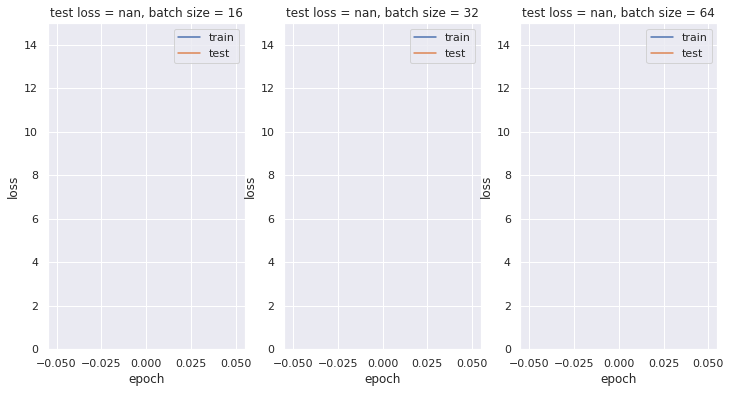

In [54]:
# Plot
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = NN_model(shape=shape)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((x_train))),
        y_train.values,
        batch_size=batch,
        validation_data=(np.array(list((x_test))), y_test.values),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 15))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}"
    )
plt.show()